### VGG-16 ###
This notebook implements the VGG-16 models. Three separate models can be created, refer to the paper for details.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
tf.config.list_physical_devices()

2.10.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# use this cell to load the balanced dataset
train_ds_bal = tf.data.Dataset.load('xBD_Dataset/xBD_train')
test_ds_bal = tf.data.Dataset.load('xBD_Dataset/xBD_test')
val_ds_bal = tf.data.Dataset.load('xBD_Dataset/xBD_val')

In [4]:
# use this cell to load the imbalanced dataset
train_ds = tf.data.Dataset.load('xBD_Dataset/xBD_train_1')
test_ds = tf.data.Dataset.load('xBD_Dataset/xBD_test_1')
val_ds = tf.data.Dataset.load('xBD_Dataset/xBD_val_1')

In [5]:
import pandas as pd
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
print(count)

ModuleNotFoundError: No module named 'pandas'

In [19]:
IMG_SIZE = (100,100)
BATCH_SIZE = 32
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,weights = None)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [20]:
def model_with_input_preprocessing(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
        
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                   weights = None,
                                                   include_top = False)

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # data preprocessing using the same weights the model was trained on
    x = tf.keras.applications.vgg16.preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x) 
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000,activation='relu')(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1,activation='linear')(x)
        
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [21]:
model2 = model_with_input_preprocessing(IMG_SIZE)

In [22]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 100, 100, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 1000)              4609

In [23]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Precision(thresholds=0),tf.keras.metrics.Recall(thresholds=0),'accuracy'])

In [17]:
# training with default model
initial_epochs = 10
history = model2.fit(train_ds, validation_data=val_ds, epochs=initial_epochs)

Epoch 1/10
2170/2170 [==============================] - 112s 51ms/step - loss: 1.0219 - precision_1: 0.7443 - recall_1: 0.4799 - accuracy: 0.8843 - val_loss: 0.2646 - val_precision_1: 0.7803 - val_recall_1: 0.7175 - val_accuracy: 0.9237
Epoch 2/10
2170/2170 [==============================] - 110s 51ms/step - loss: 0.1721 - precision_1: 0.8754 - recall_1: 0.7345 - accuracy: 0.9383 - val_loss: 0.1812 - val_precision_1: 0.8593 - val_recall_1: 0.7804 - val_accuracy: 0.9433
Epoch 3/10
2170/2170 [==============================] - 110s 51ms/step - loss: 0.1746 - precision_1: 0.8874 - recall_1: 0.7416 - accuracy: 0.9417 - val_loss: 0.1697 - val_precision_1: 0.8200 - val_recall_1: 0.8333 - val_accuracy: 0.9488
Epoch 4/10
2170/2170 [==============================] - 110s 51ms/step - loss: 0.2569 - precision_1: 0.8448 - recall_1: 0.6170 - accuracy: 0.9181 - val_loss: 0.1619 - val_precision_1: 0.8094 - val_recall_1: 0.8517 - val_accuracy: 0.9470
Epoch 5/10
2170/2170 [==============================

In [18]:
model2.save('vgg16_1.h5')

In [24]:
# training with unbalanced classes using class weights
initial_epochs = 10
history = model2.fit(train_ds, validation_data=val_ds, epochs=initial_epochs, class_weight={0:1,1:2})

Epoch 1/10
2170/2170 [==============================] - 123s 56ms/step - loss: 0.6662 - precision_2: 0.7123 - recall_2: 0.5357 - accuracy: 0.8967 - val_loss: 0.2074 - val_precision_2: 0.8727 - val_recall_2: 0.7020 - val_accuracy: 0.9337
Epoch 2/10
2170/2170 [==============================] - 138s 64ms/step - loss: 0.3403 - precision_2: 0.7790 - recall_2: 0.7290 - accuracy: 0.9271 - val_loss: 0.1757 - val_precision_2: 0.8288 - val_recall_2: 0.7895 - val_accuracy: 0.9424
Epoch 3/10
2170/2170 [==============================] - 129s 59ms/step - loss: 0.3203 - precision_2: 0.7961 - recall_2: 0.7618 - accuracy: 0.9343 - val_loss: 0.1775 - val_precision_2: 0.7866 - val_recall_2: 0.8227 - val_accuracy: 0.9428
Epoch 4/10
2170/2170 [==============================] - 137s 63ms/step - loss: 0.2606 - precision_2: 0.8172 - recall_2: 0.7983 - accuracy: 0.9431 - val_loss: 0.1834 - val_precision_2: 0.7771 - val_recall_2: 0.8397 - val_accuracy: 0.9423
Epoch 5/10
2170/2170 [==============================

In [ ]:
model2.save('vgg16_2.h5')

In [10]:
# training with balanced classes
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Precision(thresholds=0),tf.keras.metrics.Recall(thresholds=0),'accuracy'])
initial_epochs = 5
history = model2.fit(train_ds_bal, validation_data=val_ds_bal, epochs=initial_epochs)

Epoch 1/5
701/701 [==============================] - 43s 52ms/step - loss: 0.7813 - precision: 0.5493 - recall: 0.3565 - accuracy: 0.5198 - val_loss: 0.6915 - val_precision: 0.5034 - val_recall: 1.0000 - val_accuracy: 0.4966
Epoch 2/5
701/701 [==============================] - 38s 54ms/step - loss: 0.4340 - precision: 0.7897 - recall: 0.7754 - accuracy: 0.7712 - val_loss: 0.2661 - val_precision: 0.9577 - val_recall: 0.8199 - val_accuracy: 0.8783
Epoch 3/5
701/701 [==============================] - 36s 52ms/step - loss: 0.2149 - precision: 0.9232 - recall: 0.9160 - accuracy: 0.9197 - val_loss: 0.1734 - val_precision: 0.9640 - val_recall: 0.9106 - val_accuracy: 0.9322
Epoch 4/5
701/701 [==============================] - 37s 53ms/step - loss: 0.1820 - precision: 0.9365 - recall: 0.9350 - accuracy: 0.9316 - val_loss: 0.1907 - val_precision: 0.9796 - val_recall: 0.8865 - val_accuracy: 0.9168
Epoch 5/5
701/701 [==============================] - 37s 53ms/step - loss: 0.2189 - precision: 0.924

In [47]:
model2.save('vgg16_3.h5')

In [11]:
model2.evaluate(val_ds)

272/272 [==============================] - 4s 16ms/step - loss: 0.3034 - precision: 0.6269 - recall: 0.8792 - accuracy: 0.9106


[0.303388386964798, 0.6268882155418396, 0.8792372941970825, 0.9105784893035889]

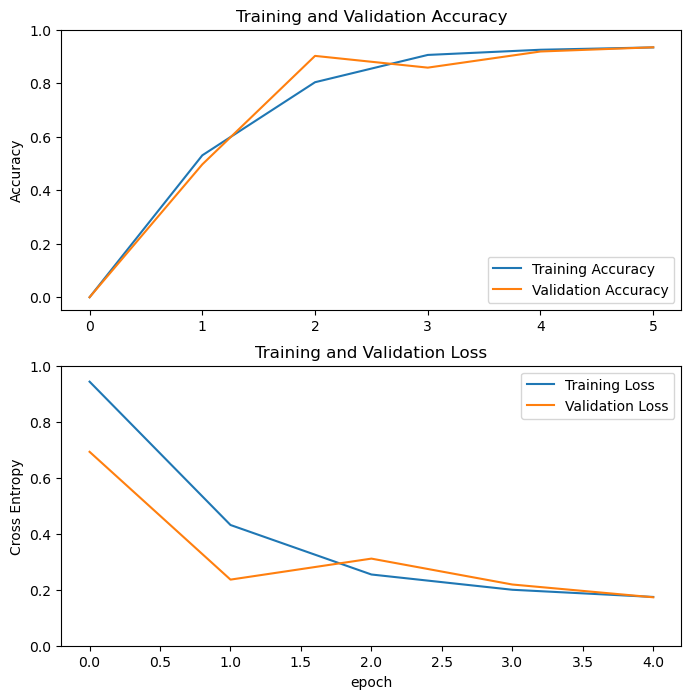

In [46]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()